In [1]:
using DrWatson
@quickactivate "momdist"

In [2]:
using Random, Plots, Pipe, Images, FileIO, ProgressMeter
using Ripserer, PersistenceDiagrams, PersistenceDiagramsBase

In [3]:
import RobustTDA as rtda

In [4]:
# Function to convert grayscale image to matrix and vice versa

function conv(X)
    if typeof(X) <: Matrix{<:Number}
        return Gray.(X)
    elseif typeof(X) <: Matrix{<:Gray}
        return map(x -> Base.convert(Float16, x), gray.(X))
    else
        @error "Not a valid datatype"
    end
end

conv (generic function with 1 method)

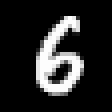

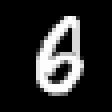

In [5]:
img = load(datadir("6.png"))

# Add adversarial contamination
img_matrix_8 = @pipe img |> conv
for u in 8:13, v in 19:20
    img_matrix_8[u, v] = 0.85
end
img_matrix_8[14, 20] = 0.85
new_img = img_matrix_8 |> conv;

display(img)
display(new_img)

In [6]:
# Sample points from Image

function sample_image(img, kludge=0.05)
    img_matrix = img |> conv
    seq = 1:28
    X = Tuple{Float64,Float64}[]
    for i in seq, j in seq
        if img_matrix_8[i, j] > 0
            X = [X; @pipe rtda.randUnif(
                        round(Int, img_matrix[i, j] * 10); a=kludge, b=1 - kludge
                    ) .|> _ .+ (j, 28 - i)
            ]
        end
    end
    return X |> rtda._ArrayOfVectors_to_ArrayOfTuples
end

sample_image (generic function with 2 methods)

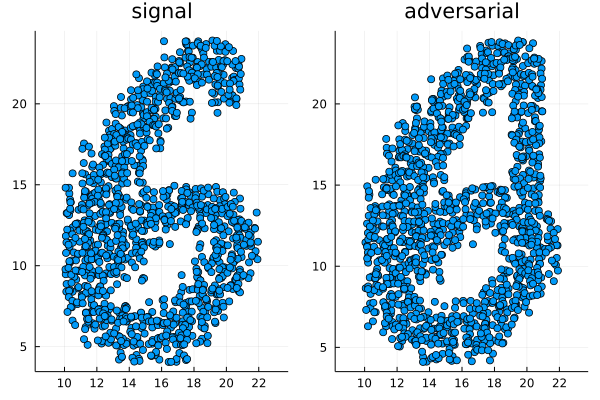

In [7]:
Random.seed!(2022)
signal = sample_image(img)
X = sample_image(new_img)

signaln = signal |> rtda._ArrayOfTuples_to_ArrayOfVectors
Xn = X |> rtda._ArrayOfTuples_to_ArrayOfVectors

plot(
    scatter(signal, ratio=1, title="signal", label=nothing),
    scatter(X, ratio=1, title="adversarial", label=nothing)
)

### MoM Dist Function

In [8]:
# m = length(Xn) - length(signaln)
Q = 0.125 * length(Xn)

Random.seed!(2022)
dnq = rtda.momdist(Xn, floor(Int, Q))
dn = rtda.dist(Xn)
d_signal = rtda.dist(signaln)

w_momdist = rtda.fit(Xn, dnq);
w_dist = rtda.fit(Xn, dn);
w_signal = rtda.fit(signaln, d_signal);

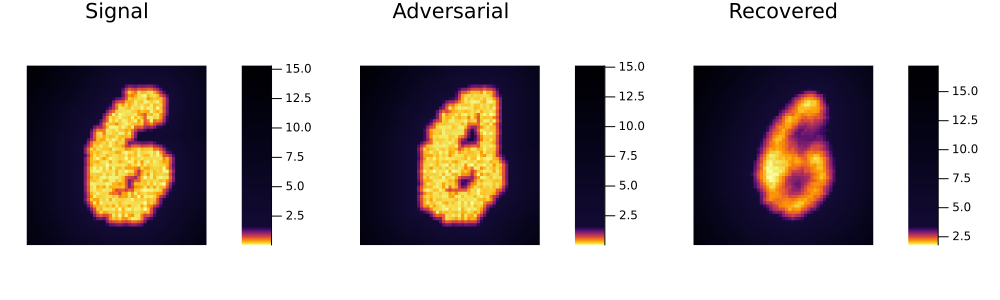

In [9]:
function heatplot(seq, fn; args...)
    G = [rtda.fit([[x, y]], fn) for x in seq, y in seq]'
    heatmap(G; axis=false, ticks=false, args...)
end

col_palette = cgrad(:inferno, 0:0.01:0.1, rev=:true)

plot(
    heatplot(0:0.5:28, c=col_palette, d_signal; ratio=1, title="Signal"),
    heatplot(0:0.5:28, c=col_palette, dn; ratio=1, title="Adversarial"),
    heatplot(0:0.5:28, c=col_palette, dnq; ratio=1, title="Recovered"),
    layout=(1,3), size=(1000,300)
)

In [10]:
D1 = @pipe signaln |> ripserer(_, dim_max=1)
D2 = @pipe Xn |> ripserer(_, dim_max=1)
D3 = @pipe Xn |> rtda.wrips(_, w=w_momdist, dim_max=1, p=2)

2-element Vector{PersistenceDiagrams.PersistenceDiagram}:
 106-element 0-dimensional PersistenceDiagram
 12-element 1-dimensional PersistenceDiagram

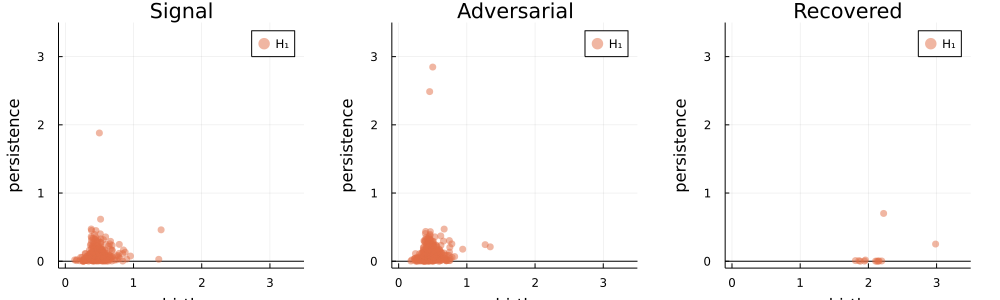

In [11]:
plot(
    plot(D1[2], title="Signal", persistence=true, lim=(-0.1,3.5), ratio=1, amrkeralpha=1),
    plot(D2[2], title="Adversarial", persistence=true, lim=(-0.1,3.5), ratio=1, amrkeralpha=1),
    plot(D3[2], title="Recovered", persistence=true, lim=(-0.1,3.5), ratio=1, amrkeralpha=1),
    layout=(1,3), size = (1000,300)
)